In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import os, sys

# Data

In [10]:
melanoma_df = pd.read_csv('melanoma_allFrames.csv')
melanoma_df.head()

,timestamp,stay_id,anchor_age,patientweight,los,gender,alb,aniongap,bun,crp,...,p-noniv,pnutrition,ponutrition,packedrbc,paralytics,sedation,tpnutrition,vasoactive,vasopressors,hours-p-iv
0,2160-10-17 19:00:00,30062923,79,147.0,1.027708,0,0.00,14.0,14.0,0.0,...,0,0,0,0,0,4,0,0,0,NaN
1,2124-04-08 03:00:00,30065290,75,69.6,2.841146,1,0.00,10.0,21.0,0.0,...,0,0,0,0,0,1,0,0,0,NaN
2,2122-04-22 04:00:00,30066446,83,82.2,6.355139,1,2.65,17.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,NaN
3,2158-06-30 18:00:00,30139247,83,75.0,2.832755,0,0.00,15.0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,NaN
4,2158-07-01 00:00:00,30139247,83,75.0,2.832755,0,0.00,15.0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,NaN


In [32]:
cohort = pd.read_csv("data/mimic-iv-1.0/icu/icustays.csv.gz", compression='gzip')
admissions = pd.read_csv("data/mimic-iv-1.0/core/admissions.csv.gz", compression='gzip')

# Dictionary of stay_id to patient_id
stay_to_hadm_id = dict(zip(cohort.stay_id, cohort.hadm_id))

hadm_id_to_death_var = dict(zip(cohort.hadm_id, admissions.deathtime))

stay_id_to_death_var = {stay_id: (1 if isinstance((hadm_id_to_death_var[hadm_id]), str) else 0) \
                        for stay_id, hadm_id in stay_to_hadm_id.items()}


In [36]:
melanoma_df["deceased"] = melanoma_df["stay_id"].map(stay_id_to_death_var)
melanoma_df.describe()

,stay_id,anchor_age,patientweight,los,gender,alb,aniongap,bun,crp,ca,...,pnutrition,ponutrition,packedrbc,paralytics,sedation,tpnutrition,vasoactive,vasopressors,hours-p-iv,deceased
count,2.587000e+03,2587.000000,2587.000000,2587.000000,2587.000000,2587.000000,2587.000000,2587.000000,2587.000000,2587.000000,...,2587.000000,2587.0,2587.000000,2587.000000,2587.000000,2587.000000,2587.000000,2587.000000,33.000000,2587.000000
mean,3.485768e+07,69.128334,79.626710,2.822425,0.344801,0.436432,12.938152,28.765752,0.891844,0.838809,...,0.000387,0.0,0.061461,0.006958,0.860843,0.000387,0.517974,0.277155,5.121212,0.036336
std,2.898909e+06,13.727789,19.018356,1.574875,0.475395,1.080087,5.750302,24.803482,12.764265,0.367778,...,0.019661,0.0,0.322660,0.111022,2.107871,0.019661,1.843019,1.291036,0.992395,0.187160
min,3.000984e+07,26.000000,1.000000,1.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,3.232798e+07,61.000000,68.100000,1.615197,0.000000,0.000000,11.000000,13.000000,0.000000,1.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
50%,3.482981e+07,70.000000,78.500000,2.333600,0.000000,0.000000,13.000000,21.000000,0.000000,1.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
75%,3.733740e+07,80.000000,89.500000,3.851343,1.000000,0.000000,16.000000,38.000000,0.000000,1.000000,...,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000
max,3.998347e+07,91.000000,172.000000,7.862882,1.000000,4.800000,42.000000,126.000000,233.100000,1.000000,...,1.000000,0.0,5.000000,2.000000,28.000000,1.000000,26.000000,23.000000,6.000000,1.000000


In [37]:
melanoma_df.to_csv('melanoma_allFrames_w_death.csv')

# Sklearn Gradient Boosting Classifier (Mortality Prediction)

In [41]:
TRAIN_COLS = ['anchor_age', 'patientweight', 'los', 'gender',
       'alb', 'aniongap', 'bun', 'crp', 'ca', 'chloride', 'creatinine',
       'fibrinogen', 'glucose', 'hgb', 'k', 'mg', 'na', 'p', 'platelets',
       'troponin', 'wbc', 'apneainterval', 'artco2p', 'arto2p', 'expratio',
       'hr', 'inspratio', 'insptime', 'nibpd', 'nibpm', 'nibps', 'pip', 'rr',
       'spo2', 'temp', 'urine', 'vm', 'vt', 'betablockers', 'ca-iv',
       'ca-noniv', 'cablockers', 'dextrose', 'fluids', 'insulin', 'k-iv',
       'hours-k-iv', 'loopdiuretics', 'mg-iv', 'mg-noniv', 'hours-mg-noniv',
       'p-iv', 'p-noniv', 'pnutrition', 'ponutrition', 'packedrbc',
       'paralytics', 'sedation', 'tpnutrition', 'vasoactive', 'vasopressors',
       'hours-p-iv']

pred_var = 'deceased'

X = melanoma_df[TRAIN_COLS]
X = X.fillna(-1)
y = melanoma_df[pred_var]

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

optimal_params = {'learning_rate': 0.359, 
                  'max_depth': 10,
                  'n_estimators': 50,
                  'min_samples_split': 4,
                  'random_state': 0}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf = GradientBoostingClassifier(**optimal_params).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9922779922779923

# Sklearn Gradient Boosting Regressor (Length of Stay Prediction)

In [57]:
from sklearn.ensemble import GradientBoostingRegressor

TRAIN_COLS = ['anchor_age', 'patientweight', 'gender',
       'alb', 'aniongap', 'bun', 'crp', 'ca', 'chloride', 'creatinine',
       'fibrinogen', 'glucose', 'hgb', 'k', 'mg', 'na', 'p', 'platelets',
       'troponin', 'wbc', 'apneainterval', 'artco2p', 'arto2p', 'expratio',
       'hr', 'inspratio', 'insptime', 'nibpd', 'nibpm', 'nibps', 'pip', 'rr',
       'spo2', 'temp', 'urine', 'vm', 'vt', 'betablockers', 'ca-iv',
       'ca-noniv', 'cablockers', 'dextrose', 'fluids', 'insulin', 'k-iv',
       'hours-k-iv', 'loopdiuretics', 'mg-iv', 'mg-noniv', 'hours-mg-noniv',
       'p-iv', 'p-noniv', 'pnutrition', 'ponutrition', 'packedrbc',
       'paralytics', 'sedation', 'tpnutrition', 'vasoactive', 'vasopressors',
       'hours-p-iv',  'deceased']

pred_var = 'los'

X = melanoma_df[TRAIN_COLS]
X = X.fillna(-1)
y = melanoma_df[pred_var]

In [59]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01}

reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 1.0455


### Plot feature importance

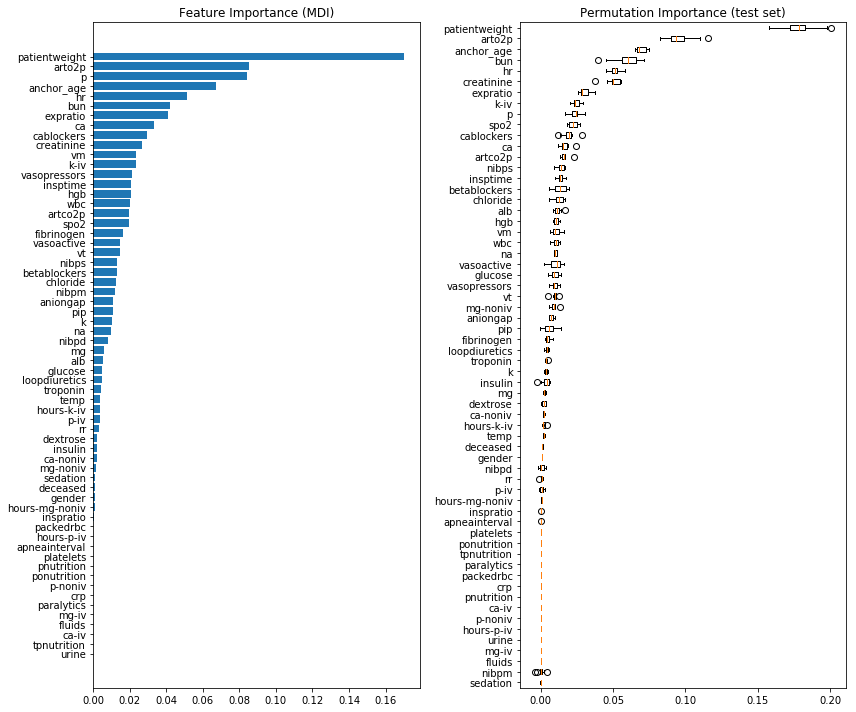

In [63]:
from sklearn.inspection import permutation_importance

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()


# XG-Boost If we want to be fancy

In [ ]:
import xgboost as xgb

TRAIN_COLS = ['anchor_age', 'patientweight', 'gender',
       'alb', 'aniongap', 'bun', 'crp', 'ca', 'chloride', 'creatinine',
       'fibrinogen', 'glucose', 'hgb', 'k', 'mg', 'na', 'p', 'platelets',
       'troponin', 'wbc', 'apneainterval', 'artco2p', 'arto2p', 'expratio',
       'hr', 'inspratio', 'insptime', 'nibpd', 'nibpm', 'nibps', 'pip', 'rr',
       'spo2', 'temp', 'urine', 'vm', 'vt', 'betablockers', 'ca-iv',
       'ca-noniv', 'cablockers', 'dextrose', 'fluids', 'insulin', 'k-iv',
       'hours-k-iv', 'loopdiuretics', 'mg-iv', 'mg-noniv', 'hours-mg-noniv',
       'p-iv', 'p-noniv', 'pnutrition', 'ponutrition', 'packedrbc',
       'paralytics', 'sedation', 'tpnutrition', 'vasoactive', 'vasopressors',
       'hours-p-iv',  'deceased']

pred_var = 'los'

X = melanoma_df[TRAIN_COLS]
X = X.fillna(-1)
y = melanoma_df[pred_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

In [ ]:
ypred = bst.predict(dtest)

In [ ]:
xgb.plot_importance(bst)

In [ ]:
xgb.plot_tree(bst, num_trees=2)